In [1]:
%cd /kaggle/working
%rm -rf /kaggle/working/*

/kaggle/working


In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import librosa

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from consts import ANGLEZ_MEAN, ANGLEZ_STD, ENMO_MEAN, ENMO_STD
from torch_model.dataset import ZzzPatchDataset
from torch_model.gru_model import ZzzTransformerGRUModule

MODEL_NAME = "spectrogram"

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base_torch(CFG["env"]["seed"])

BLOCK_SIZE = CFG[MODEL_NAME]["execution"]["block_size"]

2023-10-23 10:21:21.835292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 10:21:22.057342: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-23 10:21:22.698886: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_098


In [3]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")#[:10]
dfs = []
for file in tqdm(files):
    df = pd.read_parquet(file)
    dfs.append(df)
train = pd.concat(dfs, axis=0).reset_index(drop=True)
del dfs
gc.collect()

# targetは01にする
train["onset_target"] = train["onset_target"] / 10
train["wakeup_target"] = train["wakeup_target"] / 10

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [00:41<00:00,  6.73it/s]


,series_id,step,timestamp,anglez,enmo,event,target,onset_target,wakeup_target,fold
0,c3072a759efb,0,2018-02-26T12:15:00-0500,-87.570099,0.0287,None,1,0.0,0.0,3
1,c3072a759efb,1,2018-02-26T12:15:05-0500,-87.532402,0.0377,None,1,0.0,0.0,3
2,c3072a759efb,2,2018-02-26T12:15:10-0500,-84.158997,0.0286,None,1,0.0,0.0,3
3,c3072a759efb,3,2018-02-26T12:15:15-0500,-84.035103,0.0282,None,1,0.0,0.0,3
4,c3072a759efb,4,2018-02-26T12:15:20-0500,-84.023102,0.0279,None,1,0.0,0.0,3


(127946340, 10)

In [4]:
# BLOCK_SIZE ごとに分割
dfs = []
for series_id, df in tqdm(train.groupby("series_id")):
    df = df.sort_values("step").reset_index(drop=True)
    for start in range(0, len(df), BLOCK_SIZE // 8):
        end = start + BLOCK_SIZE
        if end > len(df):
            # endをlen(df)未満の最大のpsの倍数にする
            end = len(df) - len(df) % CFG[MODEL_NAME]["execution"]["hop_length"]
            start = end - BLOCK_SIZE
            assert start >= 0
        assert df.iloc[start]["step"] % CFG[MODEL_NAME]["execution"]["hop_length"] == 0
        dfs.append(df.iloc[start: end])
gc.collect()

100%|██████████| 277/277 [00:42<00:00,  6.58it/s]


0

In [5]:
from typing import List
import torchvision.transforms.functional as F
import albumentations as A

class ZzzSpectrogramDataset(Dataset):
    def __init__(self, dfs: List[pd.DataFrame], mode: str, patch_size: int):
        self.dfs = dfs
        self.mode = mode
        self.patch_size = patch_size

        self.transform = A.Compose([
        ])

    def __len__(self):
        return len(self.dfs)

    def __getitem__(self, index):
        df = self.dfs[index]
    
        D = librosa.stft(
            df["anglez"].values, 
            n_fft=CFG[MODEL_NAME]["execution"]["n_fft"],
            hop_length=CFG[MODEL_NAME]["execution"]["hop_length"],
            )
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        image = S_db
        # image = (image - image.mean()) / image.std()
        image = np.stack([image, image, image], axis=-1)

        image = self.transform(image=image)["image"]
        image = image.transpose(2, 0, 1)

        max_len = df.shape[0]
        patch_size = self.patch_size

        if self.mode == "train":
            targets = df[["wakeup_target", "onset_target"]].values.astype(np.float32)
            targets = targets.reshape(max_len // patch_size, patch_size, 2).mean(axis=1)
            assert targets.shape == (max_len // patch_size, 2)
            return image, targets
        else:
            return image
       

In [6]:
import albumentations as A
import segmentation_models_pytorch as smp

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from torchmetrics import MetricCollection

from transformers import get_cosine_schedule_with_warmup
import timm

seg_models = {
    "Unet": smp.Unet,
    "Unet++": smp.UnetPlusPlus,
    "MAnet": smp.MAnet,
    "Linknet": smp.Linknet,
    "FPN": smp.FPN,
    "PSPNet": smp.PSPNet,
    "PAN": smp.PAN,
    "DeepLabV3": smp.DeepLabV3,
    "DeepLabV3+": smp.DeepLabV3Plus,
}


class ZzzSpectrogramModule(pl.LightningModule):
    def __init__(
        self,
        image_size=360,
        model_size=128,
        linear_out=128,
        out_size=2,
        loss_fn=nn.CrossEntropyLoss(),
        lr=0.001,
        weight_decay=0,
        num_training_steps=1000,
    ):
        super().__init__()

        # timm-encoder
        self.encoder = timm.create_model(
            "resnet18",
            in_chans=3,
            features_only=True,
            drop_rate=0,
            drop_path_rate=0,
            pretrained=True,
        )
        g = self.encoder(torch.rand(1, 3, image_size, image_size))

        # smp-decoder
        self.n_blocks = 4
        encoder_channels = [0] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        self.decoder = smp.decoders.unet.decoder.UnetDecoder(
            encoder_channels=encoder_channels[:self.n_blocks+1],
            decoder_channels=decoder_channels[:self.n_blocks],
            n_blocks=self.n_blocks,
        )

        # seg-head
        out_dim = model_size
        self.segmentation_head = nn.Conv2d(
            decoder_channels[self.n_blocks-1], 
            out_dim, 
            kernel_size=(3, 3), 
            stride=(1, 1), 
            padding=(1, 1)
        )

        # rnn
        self.rnn = nn.GRU(model_size, model_size, batch_first=True, bidirectional=True)
        self.linear_out = nn.Sequential(
            nn.Linear(model_size * 2, linear_out),
            nn.LayerNorm(linear_out),
            nn.ReLU(),
            nn.Linear(linear_out, out_size),
        )
        self._reinitialize()

        self.loss_fn = loss_fn
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_training_steps = num_training_steps

        self.train_metrics = MetricCollection([], prefix="")
        self.valid_metrics = MetricCollection([], prefix="val_")

        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, image):
        # encoder
        features = [0] + self.encoder(image)[:self.n_blocks]

        # decoder
        features = self.decoder(*features)

        # seg-head
        features = self.segmentation_head(features)

        # 周波数方向にpooling
        features = features.mean(axis=2)

        # rnn
        features = features.transpose(1, 2)
        features, _ = self.rnn(features)

        # linear
        features = self.linear_out(features)
        return features
    
    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if "rnn" in name:
                if "weight_ih" in name:
                    nn.init.xavier_uniform_(p.data)
                elif "weight_hh" in name:
                    nn.init.orthogonal_(p.data)
                elif "bias_ih" in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4) : (n // 2)].fill_(1)
                elif "bias_hh" in name:
                    p.data.fill_(0)

    def training_step(self, batch, batch_idx):
        X, y = batch
        preds = self.forward(X)

        loss = self.loss_fn(preds, y)

        self.train_metrics(preds, y)
        self.log(
            "loss",
            loss,
            prog_bar=True,
            logger=True,
            on_epoch=True,
            on_step=True,
        )
        self.log_dict(
            self.train_metrics,
            prog_bar=True,
            logger=True,
            on_epoch=True,
            on_step=True,
        )
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        X, y = batch
        preds = self.forward(X)

        self.val_step_outputs.append(preds)
        self.val_step_labels.append(y)

    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_step_outputs)
        labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        loss = self.loss_fn(preds, labels)

        self.valid_metrics(preds, labels)
        self.log(
            "val_loss",
            loss,
            prog_bar=False,
            logger=True,
            on_epoch=True,
            on_step=False,
        )
        self.log_dict(
            self.valid_metrics,
            prog_bar=False,
            logger=True,
            on_epoch=True,
            on_step=False,
        )

        # ログをprint
        self.print_metric(preds, labels, "valid")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = get_cosine_schedule_with_warmup(optimizer, 0, self.num_training_steps)

        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def print_metric(self, y_hat, y, train_or_valid="train"):
        """
        ログをprintする。次のepochが終わると上書きされてしまうので。
        TODO: たぶんもっとマシな方法があるので探す。
        """
        if train_or_valid == "train":
            metrics = self.train_metrics
        else:
            metrics = self.valid_metrics
        loss = self.loss_fn(y_hat, y)

        print(f"[epoch {self.trainer.current_epoch}] {train_or_valid}: ", end="")
        print(f"{type(self.loss_fn).__name__}={loss:.4f}", end=", ")
        for name in metrics:
            v = metrics[name](y_hat, y)
            print(f"{name}={v:.4f}", end=", ")
        print()

torch.Size([10, 3, 320, 320]) torch.Size([10, 320, 2])
torch.Size([10, 320, 2])


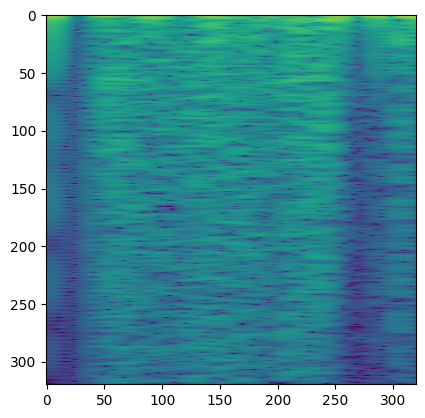

In [7]:
# debug
train_dfs = dfs[:10]
valid_dfs = dfs[:10]
train_dataset = ZzzSpectrogramDataset(train_dfs, mode="train", patch_size=CFG[MODEL_NAME]["execution"]["hop_length"])
valid_dataset = ZzzSpectrogramDataset(valid_dfs, mode="train", patch_size=CFG[MODEL_NAME]["execution"]["hop_length"])
data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

# モデル
num_training_steps = len(train_dataset) // 32 * 10
model = ZzzSpectrogramModule(
        image_size=CFG[MODEL_NAME]["execution"]["image_size"],
        model_size=128,
        linear_out=128,
        out_size=2,
        loss_fn=nn.CrossEntropyLoss(),
        lr=0.001,
        weight_decay=0,
        num_training_steps=num_training_steps,
    )

for image, label in data_module.train_dataloader():
    print(image.shape, label.shape)
    out = model(image)
    print(out.shape)
    break
plt.imshow(image[0].numpy().transpose(1, 2, 0).mean(axis=-1))
plt.show()

In [8]:
%%time

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dfs = [df for df in dfs if df["fold"].unique()[0] != fold]
    valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
    train_dataset = ZzzSpectrogramDataset(train_dfs, mode="train", patch_size=CFG[MODEL_NAME]["execution"]["hop_length"])
    valid_dataset = ZzzSpectrogramDataset(valid_dfs, mode="train", patch_size=CFG[MODEL_NAME]["execution"]["hop_length"])
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=32)

    # モデル
    num_training_steps = len(train_dataset) // 32 * 10
    model = ZzzSpectrogramModule(
            image_size=CFG[MODEL_NAME]["execution"]["image_size"],
            model_size=128,
            linear_out=128,
            out_size=2,
            loss_fn=nn.BCEWithLogitsLoss(),
            lr=0.001,
            weight_decay=0,
            num_training_steps=num_training_steps,
        )
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=8,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        deterministic=True,
        val_check_interval=0.25,
        )
    trainer.fit(model, datamodule=data_module)

    # 推論
    model = ZzzSpectrogramModule.load_from_checkpoint(
        f"logs/best_model_fold{fold}.ckpt", 
            image_size=CFG[MODEL_NAME]["execution"]["image_size"],
            model_size=128,
            linear_out=128,
            out_size=2,
            loss_fn=nn.CrossEntropyLoss(),
            lr=0.001,
            weight_decay=0,
            num_training_steps=num_training_steps,
        ).to("cuda")
    model.eval()
    preds = []
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = torch.sigmoid(model(X.to("cuda"))).detach().cpu().numpy() * 10
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.vstack(preds), valid_dfs):
        df = df.iloc[CFG[MODEL_NAME]["execution"]["patch_size"] // 2: len(df): CFG[MODEL_NAME]["execution"]["patch_size"]].reset_index(drop=True)
        df[["wakeup_oof", "onset_oof"]] = pred
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    fold_oof_dfs.append(oof_df[["series_id", "step", "wakeup_oof", "onset_oof"]])

    del model, preds, oof_df, oof_dfs
    gc.collect()
    break
train = pd.concat(fold_oof_dfs)
train.to_parquet(f"{CFG['output_dir']}/oof.parquet", index=False)
del fold_oof_dfs
gc.collect()

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.6068, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0275, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0263, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0271, 


Validation: 0it [00:00, ?it/s]

[epoch 0] valid: BCEWithLogitsLoss=0.0272, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0254, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0257, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0261, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: BCEWithLogitsLoss=0.0267, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0267, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0272, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0269, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: BCEWithLogitsLoss=0.0270, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: BCEWithLogitsLoss=0.0296, 


TypeError: ZzzTransformerGRUModule.__init__() missing 1 required positional argument: 'max_len'

In [ ]:
train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

In [ ]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)